In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
#import ofiltsky

from importlib import reload
reload(ofiltsky)

%matplotlib inline

Create a 1D array of flux values drawn from a Gaussian distribution with a fairly small sigma. Add a small constant offset to each flux (equivalent, for example to a bias level for a CCD). Then quantize and return both the floating point and the quantized versions of this array.

In [2]:
def realization(mean,sigma,offset,nsamp=1000000):
    floatmean =  stats.norm(loc=mean+offset,scale=sigma).rvs(nsamp)
    intmean = (floatmean+0.5).astype(np.int32)
    return floatmean,intmean

In [3]:
f,i = realization(100.,0.1,0.)

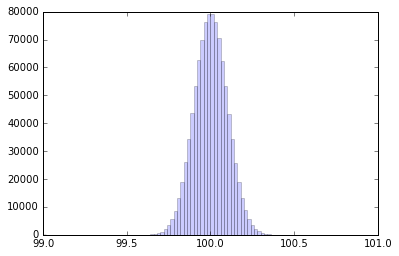

In [4]:
foo = plt.hist(f,np.arange(99.,101.,0.02),alpha=0.2)

For convenience, run ofilter and just return its estimate of the central value.

In [12]:
def ofil(data,binsize=0.1):
    return ofiltsky.fitsky_ofilter(data,sigclip_sigma=None,binsize=binsize)[0]

Now compare the estimates from three different techniques, operating on each of the floating point and the integer versions of the array: 
 * An unclipped mean
 * An unclipped median
 * ofilter

In [13]:
f0,i0 = realization(100.,1.,0.)
f1,i1 = realization(100.,1.,0.1)
f2,i2 = realization(100.,1.,0.2)
print("STD of floating point versions: ", f0.std(),f1.std(),f2.std())
print("STD of integer versions: ",i0.std(),i1.std(),i2.std())
print("Mean of floating point versions: ", f0.mean(),f1.mean(),f2.mean())
print("Mean of integer versions: ",i0.mean(),i1.mean(),i2.mean())
print("Median of float versions: ",np.median(f0),np.median(f1),np.median(f2))
print("Median of integer versions: ",np.median(i0),np.median(i1),np.median(i2))
print("Ofilt of floating point versions", ofil(f0),ofil(f1),ofil(f2))
print("Ofilt of floating point versions", ofil(i0),ofil(i1),ofil(i2))

STD of floating point versions:  0.999742145626 1.00129880511 0.999937529054
STD of integer versions:  1.04056312068 1.0422835286 1.04065540213
Mean of floating point versions:  99.9993973885 100.099483041 100.199110252
Mean of integer versions:  99.999374 100.099504 100.198845
Median of float versions:  99.9987207298 100.099802759 100.199320483
Median of integer versions:  100.0 100.0 100.0
Ofilt of floating point versions 99.9987035329 100.100223405 100.199616258
Ofilt of floating point versions 100.051718951 100.14396756 100.14258896


Results
----

All three estimates look comparable on the floating point data. 
The standard-error of the mean for one million samples if the standard deviation 
is 1.0 should be 1/sqrt(1e6) = 0.001. 
The estimate from the mean is within that for all three values of the offset, 
for both the floating point and integer versions.

The estimate from the median is okay for the floating point version, but (as expected) 
offset for the versions where there was a non-integer constant offset.

The estimate from ofilter is systematically low for the floating point version. 
It is certainly closer than the median for the integer version, but is still systematically low.

Is there a trend with the offset?
--------

Repeat the same test, varying the offset and plot the trend.

In [18]:
def repeat(realization,sigma=1.,nsamp=100000,val=100,binsize=0.1,plotmed=True):
    offset = np.arange(-1.,1.,0.02)
    fmean = offset*0.
    imean = offset*0.
    fmedian = offset*0.
    imedian = offset*0.
    fofilt = offset*0.
    iofilt = offset*0.
    for n,o in enumerate(offset):
        f,i = realization(val,sigma,o,nsamp=nsamp)
        fmean[n],fmedian[n],fofilt[n] = f.mean(),np.median(f),ofil(f,binsize=binsize)
        imean[n],imedian[n],iofilt[n] = i.mean(),np.median(i),ofil(i,binsize=binsize)
    plt.plot(offset,fmean-offset,'o',label='mean',alpha=0.3)
    if plotmed:
        plt.plot(offset,imedian-offset,'o',label='int median',alpha=0.3)
        plt.plot(offset,fmedian-offset,'s',label='float median',alpha=0.3)
    plt.plot(offset,fofilt-offset,'d',label='float ofilt',alpha=0.3)
    plt.plot(offset,iofilt-offset,'d',label='int ofilt',alpha=0.3)
    plt.legend()
#   return offset, fmean, imean, fmedian, imedian, fofilt, iofilt

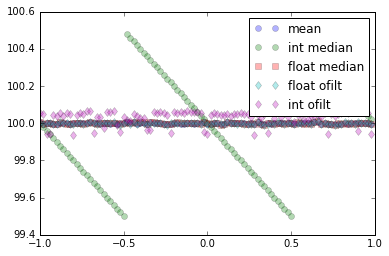

In [19]:
results = repeat(realization)

The trend is certainly systematic that the ofilt is always low. 

Is it unacceptably low?
--------
Compare the offset to the expected standard-error-of-the-mean $\sigma/\sqrt(N)$.


In [14]:
def repeat_relative(realization,sigma=5.,nsamp=100000,val=100,binsize=0.1,plotmed=True):
    offset = np.arange(-1.,1.,0.02)
    fmean = offset*0.
    imean = offset*0.
    fmedian = offset*0.
    imedian = offset*0.
    fofilt = offset*0.
    iofilt = offset*0.
    stderr = sigma/np.sqrt(nsamp)
    for n,o in enumerate(offset):
        f,i = realization(val,sigma,o,nsamp=nsamp)
        fmean[n],fmedian[n],fofilt[n] = f.mean(),np.median(f),ofil(f,binsize=binsize)
        imean[n],imedian[n],iofilt[n] = i.mean(),np.median(i),ofil(i,binsize=binsize)
    plt.plot(offset,(fmean-val-offset)/stderr,'o',label='mean',alpha=0.3)
    if plotmed:
        plt.plot(offset,(imedian-val-offset)/stderr,'o',label='int median',alpha=0.3)
        plt.plot(offset,(fmedian-val-offset)/stderr,'s',label='float median',alpha=0.3)
    plt.plot(offset,(fofilt-val-offset)/stderr,'d',label='float ofilt',alpha=0.3)
    plt.plot(offset,(iofilt-val-offset)/stderr,'d',label='int ofilt',alpha=0.3)
    plt.ylim(-50,50)
    plt.legend()

Try first with the default binsize of 0.1 (hypothesizing that the offset is due to this 
pixilization of the histogram and how you define the center). 

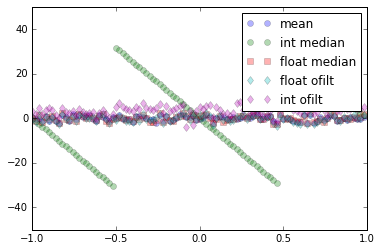

In [15]:
repeat_relative(realization)

Yes. It is unacceptably low (by nearly a factor of 20). 
Now try with a smaller binsize

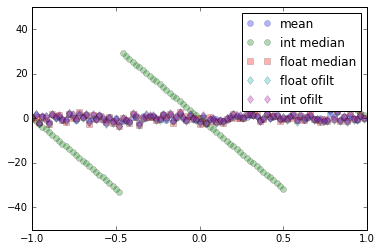

In [16]:
repeat_relative(realization,binsize=0.01)

Okay, this looks much better, but I don't think the solution is to just use a smaller binsize...I think OFILT is probably return a value that is systematically `0.5 * binsize` too low. Check this in the two next cells:

 * `binsize=0.1, sigma = 10`: off by 0.5
 * `binsize=0.1, sigma = 20`: off by 1.0
 

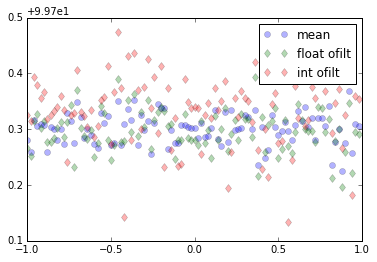

In [20]:
repeat(realization,sigma=10.,binsize=0.1,plotmed=False)

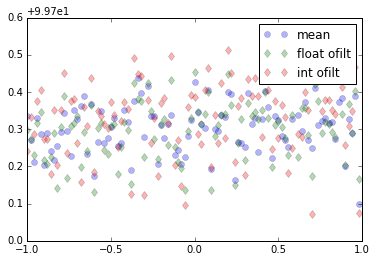

In [21]:
repeat(realization,sigma=20.,binsize=0.1,plotmed=False)

**UPDATE FROM PEY LIAN LIM: FIXED!**